# Drivers of Reddit NFL sentiment
This notebook investigates what drives the sentiment of NFL players on reddit. It roughly has N parts:
1. Building a set of covariates for sentiment (e.g. player demographics, city demographics, performance data)
2. Calculating the sentiment towards each player
3. Performing a regression model to predict player sentiment

This is a work in progress. For similar work on the NBA, see `nba-sentiment.ipynb`.

### Short term to-do:
* Clean up comment matching
  * Why does JJ Watt have low comment count?
* Add salary data and Trump vote share
* Try to find some subset of data where performance is correlated with sentiment

### Long term to-do:

Create functions for:
  * fuzzy matching cleanup
  * aggregation (maybe)

In [1]:
import json
import string
import requests
import re
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from ast import literal_eval
from string import punctuation
from sner import Ner
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\map22\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
import sports_sentiment as ss
import scrape_player_data as spd

In [3]:
# download stanford core nlp (should be a zip file of format stanford-ner-YYYY-MM-DD) (maybe from https://nlp.stanford.edu/software/CRF-NER.shtml#Download)
# need to start the Java server:
# cd C:\ProgramData\Anaconda3\Lib\site-packages\sner\stanford-ner-2018-02-27
# java -Djava.ext.dirs=./lib -cp stanford-ner.jar edu.stanford.nlp.ie.NERServer -port 9199 -loadClassifier ./classifiers/english.all.3class.distsim.crf.ser.gz  -tokenizerFactory edu.stanford.nlp.process.WhitespaceTokenizer -tokenizerOptions tokenizeNLs=false

In [4]:
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 100)

## Constants and non-text data

In [5]:
non_players_set = set('Baltimore Ravens Buffalo Bills Cincinnati Bengals Cleveland Browns Denver Broncos Houston Texans Indianapolis Colts ' \
                        'Jacksonville Jaguars Kansas City Chiefs Los Angeles Chargers Miami Dolphins New England Patriots New York Jets ' \
                        'Oakland Raiders Pittsburgh Steelers Tennessee Titans NFL Bowl ' \
                       'Arizona Cardinals Atlanta Falcons Carolina Panthers Chicago Bears Dallas Cowboys Detroit Lions Green Bay Packers ' \
                        'Los Angeles Rams Minnesota Vikings New Orleans Saints New York Giants Philadelphia Eagles San Francisco 49ers ' \
                        'Seattle Seahawks Tampa Bay Buccaneers Washington Redskins ' \
                        'Goodell Lebron jags cards hawks bucs skins'.lower().split())

In [6]:
coaches_df = pd.read_csv('d:/data/sentiment_sports/covariates/nfl_coach_performance.tsv', sep='\t')
coaches_race_df = pd.read_csv('d:/data/sentiment_sports/covariates/nfl_coach_race.tsv', sep='\t')
coaches = set([name for coach in list(coaches_race_df.iloc[:,0]) for name in coach.split(' ')] )

## Load covariates
### Covariates contains only skill position players

In [7]:
covariates_df = pd.read_csv('d:/data/sentiment_sports/covariates/nfl_player_covariates.tsv', sep='\t')
covariates_df.head(2)

,Player_FO,Tm,position,DYAR,DVOA,TD,z_DYAR,z_DVOA,z_TD,year,player_join,Player,level_1,start_year,end_year,url,height,weight,birth_date,race,salary,standard_salary,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,experience
0,T.Brady,BOS,qb,2035,35.1,34,2.574492,1.846341,1.437475,2012,t brady,tom brady,12.0,2000.0,2018.0,/players/B/BradTo00.htm,76.0,225.0,"August 3, 1977",W,NaN,NaN,12.0,4728844.0,77.3,8.0,0.3815,12.0
1,P.Manning,DEN,qb,1805,32.8,37,2.222644,1.738123,1.722051,2012,p manning,peyton manning,14.0,1998.0,2015.0,/players/M/MannPe00.htm,77.0,230.0,"March 24, 1976",W,NaN,NaN,13.0,2752056.0,81.9,5.6,0.5638,14.0


#### Also load all players so that we can get names for entity extraction

In [8]:
demo_df = pd.read_csv('d:/data/sentiment_sports/covariates/nfl_players2010-2018.tsv', sep ='\t', encoding = 'utf-8')
demo_df['Player'] = demo_df['Player'].str.lower()

### Instantiate sentiment analyzer
For sentiment, I use a modified version of VADER. Many words have different sentiment in the sports world as compared to general usage (e.g. "offensive" is not a negative word in sports).

In [9]:
sid = SentimentIntensityAnalyzer()
stat_words = ['steal', 'steals', 'block', 'blocked', 'blocks', 'slam', 'charges', 'rejection', 'free', 'assists', 'win',
              'championship', 'championships']
neutral_words = ['offense', 'offensive', 'offensively', 'defense', 'defensive', 'defensively', 'defender',
                 'injury', 'injured', 'strain', 'questionable', 'isolation', 'attack',
                 'shoot', 'doubtful', 'play', 'plays', 'crazy', 'turnover', 'turnovers',
                 'seriously', 'rob', 'freeman', 'hardy', 'threat', 'loss', 'losses', 'playing']
bad_words = ['foul', 'vicious', 'ridiculous', 'motherfucking', 'mediocre', 'soft',
             'garbage', 'delusional', 'slow', 'douchey', 'cheap', 'creepy']
great_words = ['goat', 'nasty', 'prime', 'mvp', 'master', 'all-star']
sid.lexicon.update({word:0.1 for word in stat_words})
sid.lexicon.update({word:0 for word in neutral_words})
sid.lexicon.update({word:-0.5 for word in bad_words})
sid.lexicon.update({word:1 for word in great_words})

In [10]:
city_mapping = {'ARI':'PHO', 'CAR':'CHO', 'GNB':'GB', 'JAX':'JAC', 'KAN':'KC', 'LACH':'LAC', 'LARM':'LAR',
                'NE':'BOS', 'NWE':'BOS', 'NOR':'NOP', 'NO':'NOP', 'SD':'SDG','SFO':'SF', 'TAM':'TB',
                'New England Patriots': 'BOS', 'Miami Dolphins': 'MIA', 'New York Jets': 'NYJ', 'Buffalo Bills': 'BUF',
                'Baltimore Ravens': 'BAL', 'Cincinnati Bengals': 'CIN', 'Pittsburgh Steelers': 'PIT', 'Cleveland Browns': 'CLE',
                'Houston Texans': 'HOU', 'Indianapolis Colts': 'IND', 'Tennessee Titans': 'TEN', 'Jacksonville Jaguars': 'JAC',
                'Denver Broncos': 'DEN', 'San Diego Chargers': 'SDG', 'Oakland Raiders': 'OAK', 'Kansas City Chiefs': 'KC',
                'Washington Redskins': 'WAS', 'New York Giants': 'NYG', 'Dallas Cowboys': 'DAL', 'Arizona Cardinals': 'PHO',
                'Philadelphia Eagles': 'PHI', 'Green Bay Packers': 'GB', 'Minnesota Vikings': 'MIN',
                'Chicago Bears': 'CHI', 'Detroit Lions': 'DET', 'Atlanta Falcons': 'ATL', 'Carolina Panthers': 'CHO',
                'New Orleans Saints': 'NOP', 'Tampa Bay Buccaneers': 'TB', 'San Francisco 49ers': 'SF', 'Seattle Seahawks': 'SEA',
                'St. Louis Rams': 'STL', 'Los Angeles Chargers': 'LAC', 'Los Angeles Rams': 'LAR' }

#### Player names for entity recognition and fuzzy matching
When extracting named entities, I had to be careful with some names that are common English words (e.g. "Brown"). As a shorter alternative to performing NER, I also sometimes simply extracted player names as keywords.

In [11]:
UNIQUE_NAMES = {x.replace('\\', '') for x in set(demo_df.Player.unique())}
UNIQUE_NAMES = UNIQUE_NAMES.union(set(coaches_race_df.iloc[:,0].str.lower()))

In [12]:
NAMED_ENTITIES = set(' '.join(UNIQUE_NAMES).split()).union({'rg3', 'obj', 'saquads', 'cantguardmike', 'tractorcito', 'bmarsh',
                                                            'berman', 'coughlin', 'dungy', 'mcdaniels', 'spanos', 'gronk', 'bledsoe', 'garopolo'})
NAMED_ENTITIES = NAMED_ENTITIES.union(non_players_set)
# some players have common word names; don't want to detect those as entities when lowercase, but do want to when uppercase
UPPER_ENTITIES = {'Ah', 'Black', 'Ball', 'Battle', 'Bell', 'Best', 'Blue', 'Board', 'Brown', 'Buddy', 'Burden',
                  'Case', 'Chance', 'Choice', 'City', 'Cook', 'Dare', 'Day', 'Early',
                  'Fish', 'Free', 'Grant', 'Good', 'Hand', 'Heard', 'Hill', 'Hope', 'Hurt', 'House', 'Holiday', 'Key',
                  'Little', 'Guy', 'Long', 'Love', 'Light', 'Line', 'Luck', 'Major', 'Means', 'New', 
                  'Pace', 'Person', 'Petty','Pool', 'Price','Rob', 'Rose', 'Red', 'Rock', 'Rush',
                  'Savage', 'Season', 'Short', 'Shorts', 'Strong', 'Small', 'Smart', 'Star', 'Stone', 'Story', 
                  'Temple', 'Tuck', 'Wall', 'Wear', 'Weeks', 'White', 'Will', 'Way', 'West', 'Wise', 'Young', 'Gay' }
NAMED_ENTITIES = NAMED_ENTITIES - {'a', 'g', 'ah', 'you', 'has', 'good', 'still'} - {name.lower() for name in UPPER_ENTITIES}
# remove periods for some names
table = str.maketrans({key: None for key in string.punctuation})
NOPUNCT_ENTITIES = {name.translate(table) for name in NAMED_ENTITIES}
NAMED_ENTITIES = NAMED_ENTITIES.union(NOPUNCT_ENTITIES)

In [13]:
text_col = 'sentences'
def create_month_df(data_loc):
    return ss.create_sentiment_df(data_loc, sid.polarity_scores, ner_set=NAMED_ENTITIES,
                                  non_players_set=non_players_set, UPPER_NAMES = UPPER_ENTITIES, TEXT_COL = text_col)[1]

## Calculate sentiment 
### Reddit sentiment for 2017-18 season
I created a module, `sentiment_sports` to calculate the sentiment of comments. This function performs a few things:
1. Separates comments into sentences
2. Performs Named entity recognition using either NLTK, or using pre-existing list of entities
3. Calculates sentiment using VADER with a modified lexicon

In [ ]:
%%time
file_stub = 'd:/data/sentiment_sports/nfl_reddit_comments/{}-comments_submissions.tsv'
year_dfs = [create_month_df(file_stub.format(year)) for year in [201709, 201710, 201711, 201712, 201801, 201802]]
nfl2017_df = pd.concat(year_dfs)
nfl2017_df.shape

In [35]:
%%time
# 27 minutes with 8 cores
nfl2017_df = ss.fuzzy_match_players(nfl2017_df, UNIQUE_NAMES, num_workers=5)

Fuzzy matching player names
Wall time: 28min 48s


#### 2016-2017 season

In [ ]:
%%time
file_stub = 'd:/data/sentiment_sports/nfl_reddit_comments/{}-comments_submissions.tsv'
year_dfs = [create_month_df(file_stub.format(year)) for year in [201609, 201610, 201611, 201612, 201701, 201702]]
nfl2016_df = pd.concat(year_dfs)
nfl2016_df.shape

In [15]:
%%time
# 27 minutes with 8 cores
nfl2016_df = ss.fuzzy_match_players(nfl2016_df, UNIQUE_NAMES)

Fuzzy matching player names
Wall time: 22min 50s


In [68]:
nfl2016_df.to_csv('d:/data/sentiment_sports/nfl2016_ner_sentiment.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### 2015-2016 season

In [ ]:
%%time
file_stub = 'd:/data/sentiment_sports/nfl_reddit_comments/{}-comments_submissions.tsv'
year_dfs = [create_month_df(file_stub.format(year)) for year in [201509, 201510, 201511, 201512, 201601, 201602]]
nfl2015_df = pd.concat(year_dfs)
nfl2015_df.shape

In [18]:
%%time
# 27 minutes with 8 cores
nfl2015_df = ss.fuzzy_match_players(nfl2015_df, UNIQUE_NAMES)

Fuzzy matching player names
Wall time: 23min 9s


In [71]:
nfl2015_df.to_csv('d:/data/sentiment_sports/nfl2015_ner_sentiment.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### 2014-2015 season

In [ ]:
%%time
file_stub = 'd:/data/sentiment_sports/nfl_reddit_comments/{}-comments_submissions.tsv'
year_dfs = [create_month_df(file_stub.format(year)) for year in [201409, 201410, 201411, 201412, 201502]]
nfl2014_df = pd.concat(year_dfs)
nfl2014_df.shape

In [18]:
%%time
# 27 minutes with 8 cores
nfl2014_df = ss.fuzzy_match_players(nfl2014_df, UNIQUE_NAMES)

Fuzzy matching player names
Wall time: 18min 38s


In [16]:
nfl2014_df.to_csv('d:/data/sentiment_sports/nfl2014_ner_sentiment.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### 2013-2014 season

In [ ]:
%%time
file_stub = 'd:/data/sentiment_sports/nfl_reddit_comments/{}-comments_submissions.tsv'
year_dfs = [create_month_df(file_stub.format(year)) for year in [201309, 201310, 201311, 201312, 201401, 201402]]
nfl2013_df = pd.concat(year_dfs)
nfl2013_df.shape

In [48]:
%%time
# 27 minutes with 8 cores
nfl2013_df = ss.fuzzy_match_players(nfl2013_df, UNIQUE_NAMES)

Fuzzy matching player names
Wall time: 19min 45s


In [49]:
nfl2013_df.to_csv('d:/data/sentiment_sports/nfl2013_ner_sentiment.tsv', sep='\t',
               index=False, encoding = 'utf-8')

### Load comment sentiment

In [14]:
%%time
nfl2013_df = pd.read_csv('d:/data/sentiment_sports/nfl2013_ner_sentiment.tsv',sep='\t', encoding = 'utf-8')
nfl2013_df['named_entities'] = nfl2013_df['named_entities'].apply(literal_eval)
nfl2014_df = pd.read_csv('d:/data/sentiment_sports/nfl2014_ner_sentiment.tsv',sep='\t', encoding = 'utf-8')
nfl2014_df['named_entities'] = nfl2014_df['named_entities'].apply(literal_eval)
nfl2015_df = pd.read_csv('d:/data/sentiment_sports/nfl2015_ner_sentiment.tsv',sep='\t', encoding = 'utf-8')
nfl2015_df['named_entities'] = nfl2015_df['named_entities'].apply(literal_eval)
nfl2016_df = pd.read_csv('d:/data/sentiment_sports/nfl2016_ner_sentiment.tsv',sep='\t', encoding = 'utf-8')
nfl2016_df['named_entities'] = nfl2016_df['named_entities'].apply(literal_eval)
nfl2017_df = pd.read_csv('d:/data/sentiment_sports/nfl2017_ner_sentiment.tsv',sep='\t', encoding = 'utf-8')
nfl2017_df['named_entities'] = nfl2017_df['named_entities'].apply(literal_eval)

<string>:2: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.


Wall time: 39.5 s


In [15]:
nfl2013_df['year'] = 2013
nfl2014_df['year'] = 2014
nfl2015_df['year'] = 2015
nfl2016_df['year'] = 2016
nfl2017_df['year'] = 2017

In [16]:
nfl_df = pd.concat([nfl2013_df, nfl2014_df, nfl2015_df, nfl2016_df, nfl2017_df])

C:\Users\map22\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


#### Cleaning up name matches
Some extracted name entities don't have a clear match (e.g. "Rivers" could be Austin Rivers or Doc Rivers). Here we clean those out

In [17]:
name_map = {name:'unclear' for name in ['rivers', 'bird', 'brady moss']}
name_map.update({'barr':'anthony barr', 'bmarsh':'brandon marshall', 'brady': 'tom brady', 'carr':'derek carr', 
                 'carson': 'carson palmer', 'clowney': 'jadeveon clowney', 'cousins': 'kirk cousins', 'crabtree':'michael crabtree', 
                'dak':'dak prescott', 'dalton':'andy dalton', 'dez': 'dez bryant', 'eli': 'eli manning', 'ertz':'zach ertz', 'freeman':'devonta freeman',
                 'goff':'jared goff', 'gore':'frank gore', 'gronk':'rob gronkowski', 'gurley':'todd gurley',
                 'ingram': 'mark ingram', 'jj': 'j.j. watt', 'kamara':'alvin kamara', 'kelce': 'travis kelce',
                 'landry': 'jarvis landry', 'mccarron':'aj mccarron', 'obj': 'odell beckham',
                 'peyton':'peyton manning', 'peterman':'nathan peterman', 'pryor':'terrelle pryor',
                 'rodgers':'aaron rodgers', 'stafford':'matthew stafford', 'saquads': 'saquon barkley', 'tractorcito': 'derrick henry',
                'vick': 'michael vick', 'watt':'j.j. watt', 'rg3':'robert griffin'})

In [18]:
%%time
nfl_df['fuzzy_name'] = nfl_df.apply(lambda row: name_map[row['str_entities']] if row['str_entities'] in name_map else row['fuzzy_name'], axis=1)

Wall time: 54.3 s


Remove players whose names have implicit sentiment

In [19]:
senti_players = ['maurice hurt', 'chris hope', 'tom savage', 'chandler burden', 'bryce petty',
                 'andrew luck', 'lucky whitehead', 'jahvid best', 'champ bailey']
nfl_df = nfl_df[nfl_df['fuzzy_name'].apply(lambda row: row not in senti_players)]

#### Query to investigate non-mappings

#### Combine seasons into a single dataframe

In [20]:
match_df = nfl_df.query('fuzzy_name != "unclear"')
match_df.shape

(1238563, 20)

### User-level metrics

In [23]:
user_df = match_df.groupby('user').agg({'score':['sum', 'count', 'mean']}).fillna(0)
user_df.columns = ['user_total_score', 'user_total_comments', 'user_mean_score']

#### First calculate the average sentiment for each player from each user

In [24]:
user_player_sentiment_df = (match_df.groupby(['fuzzy_name', 'user', 'year', 'flair'])
                                    .agg({'compound':['mean', 'std', 'count']})
                                    .reset_index())
user_player_sentiment_df.columns = ['fuzzy_name', 'user', 'year', 'flair', 'compound_mean', 'compound_std', 'comment_count']
user_player_sentiment_df.head(1)

,fuzzy_name,user,year,flair,compound_mean,compound_std,comment_count
0,a'shawn robinson,AshytooClassy,2017,Lions,0.0,NaN,1


#### Match user flairs to teams

In [25]:
city_mapping.update({'Falcons':'ATL', 'Ravens':'BAL', 'Patriots':'BOS', 
                     'Panthers':'CHO', 'Browns':'CLE', 'Bears':'CHI',
                'Cowboys':'DAL', 'Broncos':'DEN', 'Lions':'DET', 
                'Lakers':'LAL', 'Rams':'LAR', 
              'Giants':'NYG',  'Jets':'NYJ', 'Texans':'HOU',
              'Vikings':'MIN', 'Dolphins':'MIA',
              'Eagles':'PHI', 'Cardinals':'PHO', 
              'Colts':'IND','Redskins':'WAS', 
              'Saints':'NOP', 'Titans':'TEN', 
              'Packers':'GB', 'Seahawks':'SEA', 'Steelers':'PIT','Raiders':'OAK',
                'Chiefs':'KC','Bills':'BUF', 'Jaguars':'JAC', '49ers':'SF',
                'Chargers':'LAC', 'Bengals':'CIN', 'Buccaneers':'TB'})
def get_flair(flair_string, flair_dict, flair_regex):
    ''' Match flairs that are team name, or have team abbreviation within brackets'''
    if flair_string in flair_dict:
        return flair_dict[flair_string]
    elif re.match(flair_regex, flair_string):
        return re.search(flair_regex, flair_string).groups(1)[0]
    return 'no_team'
flair_regex = '^\[(\w{3})\]'
user_player_sentiment_df['user_Tm'] = user_player_sentiment_df['flair'].apply(lambda row: get_flair(row, city_mapping, flair_regex))

In [26]:
city_df = pd.read_csv('d:/data/sentiment_sports/covariates/sports_metro_demographics.csv').drop(columns = ['census_Id', 'census_Id2', 'Geography'])
vote_df = pd.read_csv('d:/data/sentiment_sports/covariates/msa_votes.tsv', sep='\t')[['per_point_diff', 'Tm']].rename(columns={'per_point_diff':'clinton_vote_lead'})

In [27]:
user_player_regression_df = (user_player_sentiment_df.rename(columns = {'fuzzy_name':'Player'})
                         .merge(covariates_df, on = ['Player', 'year'], how = 'left')
                         .merge(user_df, on='user', how='left'))
user_player_regression_df['team_match'] = user_player_regression_df['Tm'] == user_player_regression_df['user_Tm']
user_player_regression_df = (user_player_regression_df.drop(columns = ['metro_percent_white', 'metro_percent_black', 'clinton_vote_lead', 'total_population'])
                                    .merge(vote_df.rename(columns = {'Tm':'user_Tm'}), on='user_Tm', how='left')
                                    .merge(city_df.rename(columns = {'Tm':'user_Tm'}), on='user_Tm', how='left'))
user_player_regression_df['youth'] = (user_player_regression_df['experience'].mean() - user_player_regression_df['experience']).clip(0)
user_player_regression_df['oldness'] = (user_player_regression_df['experience'] - user_player_regression_df['experience'].mean()).clip(0)
user_player_regression_df['rookie'] = user_player_regression_df['experience'] <=4
user_player_regression_df['white_black_diff'] = user_player_regression_df['metro_percent_white'] - user_player_regression_df['metro_percent_black']
user_player_regression_df['height_dummies'] = pd.cut(user_player_regression_df['height'], [0, 72, 100], labels = ['short', 'tall'])
user_player_regression_df['standard_salary'] = user_player_regression_df['standard_salary'].fillna(user_player_regression_df['standard_salary'].mean())

In [28]:
user_player_regression_df.to_csv('d:/data/sentiment_sports/nfl_user_player_sentiment.tsv', sep='\t', index=False)
#user_player_regression_df = pd.read_csv('d:/data/sentiment_sports/nfl_user_player_sentiment.tsv', sep='\t')

#### Then calculate the average sentiment to players across all users

In [30]:
player_sentiment_df = (user_player_sentiment_df.query('compound_mean != 0')
                                               .groupby(['fuzzy_name', 'year'])
                                               .agg({'compound_mean':['mean', 'std', 'count']})
                                               .reset_index() )
player_sentiment_df.columns = ['fuzzy_name', 'year', 'compound_mean_mean', 'compound_mean_std', 'user_count']

### Exploration of sentiment alone
Plot of player popularity (number of users who comment on them), versus sentiment

Text(0,0.5,'Mean sentiment')

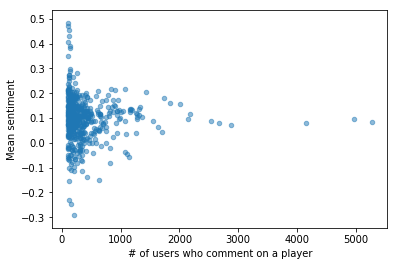

In [94]:
player_sentiment_df.query('user_count> 100').plot('user_count', 'compound_mean_mean', kind='scatter', alpha = 0.5)
#plt.plot([100, 100], [-0.1, 0.3])
plt.xlabel('# of users who comment on a player')
plt.ylabel('Mean sentiment')

#### Most commented players

In [95]:
player_sentiment_df.sort_values('user_count', ascending=False).head()

,fuzzy_name,year,compound_mean_mean,compound_mean_std,user_count
8215,tom brady,2017,0.085859,0.382076,5273
8214,tom brady,2016,0.095046,0.381020,4965
8213,tom brady,2015,0.079699,0.382783,4152
6770,peyton manning,2015,0.070516,0.391246,2884
63,aaron rodgers,2016,0.078407,0.396450,2674


#### Players with lowest sentiment

In [96]:
player_sentiment_df.query('user_count > 100').sort_values('compound_mean_mean').head()

,fuzzy_name,year,compound_mean_mean,compound_mean_std,user_count
3391,gregg williams,2017,-0.292426,0.401353,212
6095,michael bennett,2017,-0.246168,0.432726,166
3390,gregg williams,2016,-0.229989,0.425208,131
2157,danny trevathan,2017,-0.152300,0.452943,121
8634,vontaze burfict,2015,-0.148928,0.418612,627


#### Players with highest sentiment

In [97]:
player_sentiment_df.query('user_count > 200').sort_values('compound_mean_mean').tail(5)

,fuzzy_name,year,compound_mean_mean,compound_mean_std,user_count
7006,reggie corner,2016,0.212758,0.432695,898
3559,j.j. watt,2016,0.215113,0.359252,1068
3560,j.j. watt,2017,0.217987,0.365602,840
2324,david johnson,2016,0.240712,0.417744,228
7567,sean mcvay,2017,0.280502,0.392170,267


In [98]:
# temporary until I re-run sentiment scoring
player_sentiment_df = player_sentiment_df.query('fuzzy_name != "devonta freeman"')

#### Players with highest std of sentiment

In [99]:
player_sentiment_df.query('user_count > 200').sort_values('compound_mean_std').tail(5).iloc[::-1]

,fuzzy_name,year,compound_mean_mean,compound_mean_std,user_count
6980,ray lewis,2015,-0.066220,0.508156,230
3665,jake locker,2017,-0.022028,0.495409,823
3651,jake butt,2016,-0.072136,0.485159,350
3664,jake locker,2016,-0.013472,0.480238,663
5133,kevin boss,2017,0.016014,0.472658,406


#### Join player sentiment to performance and demographics
Include only players with at least 100 comments to avoid fitting noise

In [31]:
join_df = (player_sentiment_df.query('user_count >= 10')
                         .merge(covariates_df, left_on = ['fuzzy_name', 'year'],
                                                right_on = ['Player', 'year'])
                        )

### Explore demographics relationship with sentiment

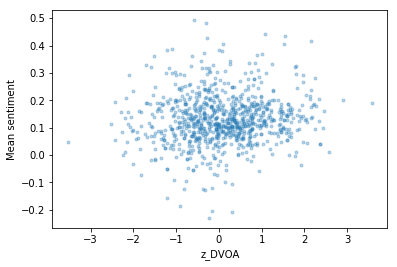

In [32]:
plt.plot(join_df['z_DVOA'].values, join_df['compound_mean_mean'].values, '.',alpha= 0.3);
plt.xlabel('z_DVOA')
plt.ylabel('Mean sentiment');

In [33]:
join_df.groupby('race').mean()

,year,compound_mean_mean,compound_mean_std,user_count,DYAR,DVOA,TD,z_DYAR,z_DVOA,z_TD,level_1,start_year,end_year,height,weight,salary,standard_salary,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,experience
race,,,,,,,,,,,,,,,,,,,,,,,
B,2014.977702,0.136303,0.422472,110.399657,104.138937,0.644768,6.013722,0.035807,0.011971,0.133425,4.094340,2010.903945,2017.276158,72.674099,214.970840,4.088832e+06,14.703781,7.986278,4.830830e+06,69.584906,15.749743,0.333479,4.073756
L,2014.000000,0.111000,0.417682,162.000000,91.333333,-0.666667,4.333333,0.224904,-0.147852,-0.055956,8.000000,2005.666667,2015.000000,73.666667,219.666667,4.400000e+06,15.297115,7.333333,1.522522e+07,57.500000,22.566667,0.552600,8.333333
M,2015.000000,0.018989,0.458930,17.500000,117.500000,28.550000,3.500000,0.488192,1.560898,-0.031140,5.000000,2010.000000,2016.500000,72.000000,206.000000,2.746000e+06,14.825656,12.000000,3.648984e+06,62.850000,27.900000,0.664550,5.000000
S,2015.000000,0.131202,0.443592,252.111111,135.111111,-2.900000,9.777778,-0.195090,-0.167218,0.105338,2.333333,2012.555556,2017.000000,75.888889,234.333333,2.735576e+06,14.376689,6.888889,2.690718e+06,75.055556,15.566667,0.288634,2.444444
W,2014.866667,0.119285,0.419556,463.552941,290.576471,3.884314,13.129412,0.265109,0.232007,0.172663,5.772549,2009.074510,2017.309804,75.552941,229.639216,7.526753e+06,15.259475,8.372549,4.854990e+06,70.780784,15.344314,0.347666,5.792157


#### Age / experience

Text(0,0.5,'Mean sentiment')

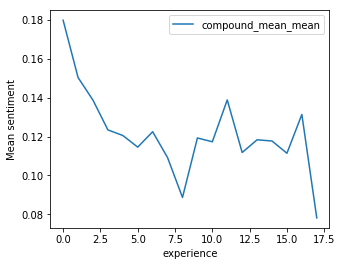

In [34]:
fig, ax1 = plt.subplots(1,1, figsize = [5, 4], sharey=True)
join_df.groupby('experience').mean().reset_index().plot('experience', 'compound_mean_mean', ax = ax1);
ax1.set_ylabel('Mean sentiment')

#### Height

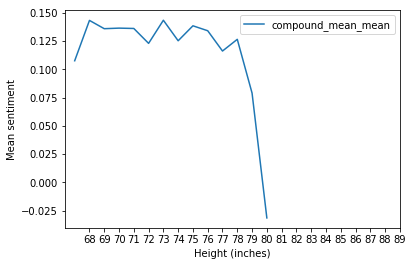

In [35]:
join_df.groupby('height').mean().reset_index().plot('height', 'compound_mean_mean');
plt.xticks(range(68,90,1) );
plt.xlabel('Height (inches)')
plt.ylabel('Mean sentiment');

### Team and position

In [36]:
join_df.groupby('position').mean().reset_index()

,position,year,compound_mean_mean,compound_mean_std,user_count,DYAR,DVOA,TD,z_DYAR,z_DVOA,z_TD,level_1,start_year,end_year,height,weight,salary,standard_salary,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,experience
0,qb,2014.875000,0.112851,0.419016,679.562500,399.539773,-0.302841,19.812500,0.034534,0.049429,0.053473,5.920455,2008.909091,2017.460227,75.375000,224.255682,9.831701e+06,15.549917,7.562500,4.986120e+06,70.020455,15.311364,0.341755,5.965909
1,rb,2014.955556,0.137158,0.426211,92.672222,70.600000,-0.465000,5.833333,0.030278,0.012706,0.121017,3.766667,2011.294444,2017.188889,71.122222,219.894444,2.975282e+06,14.419351,8.116667,4.819916e+06,69.682222,15.955000,0.338489,3.661111
2,te,2014.916084,0.132552,0.422830,93.993007,61.965035,4.809790,4.503497,0.305084,0.209057,0.336428,5.000000,2009.930070,2017.209790,76.615385,254.223776,3.632927e+06,14.719151,8.447552,4.457277e+06,69.996503,16.166434,0.342296,4.986014
3,wr,2014.977337,0.135777,0.420742,100.946176,126.478754,2.392635,5.045326,0.094104,0.074879,0.122466,4.189802,2010.764873,2017.249292,72.688385,203.008499,4.363012e+06,14.806699,8.212465,4.954827e+06,70.013881,15.524079,0.336069,4.212465


#### Create modeling dataframe

In [37]:
join_df['youth'] = (join_df['experience'].mean() - join_df['experience']).clip(0)
join_df['oldness'] = (join_df['experience'] - join_df['experience'].mean()).clip(0)
join_df['rookie'] = join_df['experience'] <=1

In [38]:
join_df['white_black_diff'] = join_df['metro_percent_white'] - join_df['metro_percent_black']
join_df['height_dummies'] = pd.cut(join_df['height'], [0, 72, 100], labels = ['short', 'tall'])
join_df['standard_salary'] = join_df['standard_salary'].fillna(join_df['standard_salary'].mean())

In [39]:
#join_df.to_csv('modeling_data/nfl_model_data.tsv', sep='\t', index=False)

In [40]:
fit_df = join_df.copy().query('user_count > 20').replace({'L':'B', 'S':'B', 'M':'B'})

## Regression models

### Salary
#### Exploration

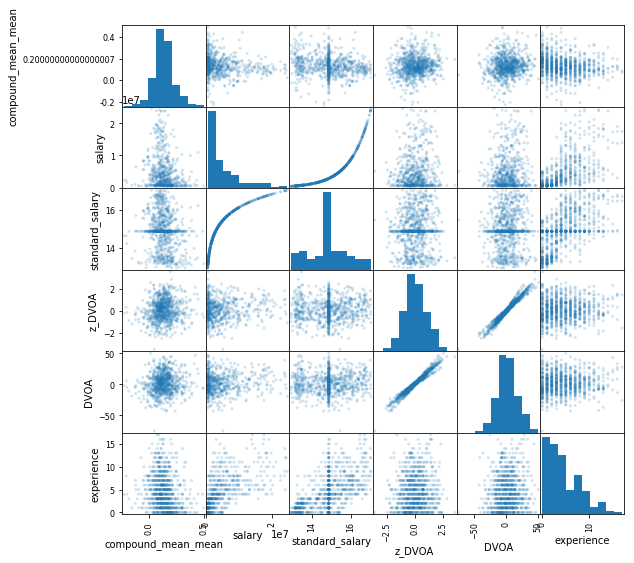

In [41]:
from pandas.plotting import scatter_matrix
scatter_matrix(join_df[['compound_mean_mean', 'salary', 'standard_salary', 'z_DVOA', 'DVOA', 'experience']], alpha=0.2, figsize=(9, 9));

In [42]:
join_df.groupby('position').mean()[['salary', 'standard_salary']]

,salary,standard_salary
position,,
qb,9.831701e+06,15.343171
rb,2.975282e+06,14.550087
te,3.632927e+06,14.770583
wr,4.363012e+06,14.821467


#### Regression

In [43]:
salary_model = smf.wls( formula = 'standard_salary ~ rookie + position + z_DVOA',
                data = fit_df,
               weights = 1,
#                missing='raise'   
               ).fit()

In [44]:
salary_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        standard_salary   R-squared:                       0.249
Model:                            WLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     45.26
Date:                Thu, 20 Dec 2018   Prob (F-statistic):           2.14e-40
Time:                        23:24:06   Log-Likelihood:                -850.61
No. Observations:                 690   AIC:                             1713.
Df Residuals:                     684   BIC:                             1740.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         15.5592      0.065    238.667      0.000      15.431      15.687
rookie[T.True]    -0.9790      0.077    -12.662      0.000      -1.131      -0.827
position[T.rb]    -0.6758      0.094     -7.177      0.000      -0.861      -0.491
position[T.te]    -0.5212      0.109     -4.768      0.000      -0.736      -0.307
position[T.wr]    -0.4650      0.080     -5.811      0.000      -0.622      -0.308
z_DVOA             0.0180      0.033      0.555      0.579      -0.046       0.082
==============================================================================
Omnibus:                       18.036   Durbin-Watson:                   1.546
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.780
Skew:                          -0.218   Prob(JB):                      0.00168
Kurtosis:                       2.496   Cond. No.                         5.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Calculate residual salary

In [45]:
fit_df['pred_std_salary'] = salary_model.predict(fit_df)
fit_df['std_salary_resid'] = fit_df['pred_std_salary']- fit_df['standard_salary']
fit_df.sort_values('std_salary_resid').head(5)[['Player', 'year', 'standard_salary', 'pred_std_salary']]

,Player,year,standard_salary,pred_std_salary
126,calvin johnson,2015,16.838761,15.107814
10,adrian peterson,2015,16.549878,14.886236
316,ezekiel elliott,2017,15.551034,13.921549
211,deandre hopkins,2017,16.705882,15.108240
259,dez bryant,2017,16.648724,15.076311


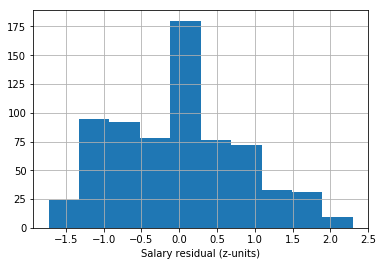

In [46]:
fit_df['std_salary_resid'].hist();
plt.xlabel('Salary residual (z-units)');

### Sentiment regression model

In [78]:
simple_model = smf.wls( formula = 'compound_mean_mean ~ z_DVOA * C(race) + youth + oldness + rookie + position + Wins   + standard_salary + std_salary_resid',#\
                       #' + white_black_diff * C(race) + clinton_vote_lead',',#'
                data = fit_df,
               weights = 1 / (fit_df['compound_mean_std'] / np.sqrt(fit_df['user_count'])),
#                missing='raise'   
               ).fit(cov_type='cluster', cov_kwds={'groups' : fit_df['Player']})

In [79]:
simple_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.114
Model:                            WLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     155.7
Date:                Thu, 20 Dec 2018   Prob (F-statistic):          3.24e-117
Time:                        23:34:59   Log-Likelihood:                 873.67
No. Observations:                 690   AIC:                            -1723.
Df Residuals:                     678   BIC:                            -1669.
Df Model:                          11                                         
Covariance Type:              cluster                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0057      0.001      5.111      0.000       0.003       0.008
C(race)[T.W]            0.0019      0.009      0.211      0.833      -0.016       0.019
rookie[T.True]          0.0354      0.012      2.841      0.004       0.011       0.060
position[T.rb]          0.0303      0.009      3.226      0.001       0.012       0.049
position[T.te]          0.0161      0.011      1.458      0.145      -0.006       0.038
position[T.wr]          0.0194      0.010      2.011      0.044       0.000       0.038
z_DVOA                  0.0129      0.004      3.201      0.001       0.005       0.021
z_DVOA:C(race)[T.W]    -0.0005      0.005     -0.092      0.927      -0.010       0.009
youth                   0.0025      0.003      0.775      0.439      -0.004       0.009
oldness                -0.0006      0.001     -0.519      0.604      -0.003       0.002
Wins                   -0.0014      0.001     -1.637      0.102      -0.003       0.000
standard_salary         0.0067      0.001      7.984      0.000       0.005       0.008
std_salary_resid        0.0091      0.003      2.778      0.005       0.003       0.016
==============================================================================
Omnibus:                       25.630   Durbin-Watson:                   1.590
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.335
Skew:                           0.184   Prob(JB):                     1.59e-12
Kurtosis:                       4.325   Cond. No.                     1.39e+17
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
[2] The smallest eigenvalue is 3.59e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Coaches

In [30]:
coaches_df = pd.read_csv('d:/data/sentiment_sports/covariates/nfl_coach_performance.tsv', sep='\t')
coaches_race_df = pd.read_csv('d:/data/sentiment_sports/covariates/nfl_coach_race.tsv', sep='\t')

In [31]:
team_win_df = coaches_df.groupby(['Tm', 'year']).sum()['W'].reset_index()
team_win_df['season_WinP'] = team_win_df['W'] / 16
team_win_df.sample(5)

,Tm,year,W,season_WinP
663,Denver Broncos,1981,10.0,0.6250
1541,Oakland Raiders,1976,13.0,0.8125
941,Houston Texans,2003,5.0,0.3125
593,Dallas Cowboys,1985,10.0,0.6250
1272,Minnesota Vikings,2018,4.0,0.2500


In [32]:
coach_tenure = coaches_df.groupby(['Tm', 'Coach']).apply(lambda df: df.rank())[['year']].rename(columns={'year':'tenure'})
coaches_df = coaches_df.join(coach_tenure)
coaches_df['rookie'] = coaches_df['tenure'] == 1

In [33]:
coaches_df['prev_year'] = coaches_df['year']-1
coaches_df = coaches_df.merge(team_win_df.rename(columns = {'year': 'prev_year'}),
                              on = ['prev_year', 'Tm'], how='left', suffixes = ('', '_prev') )
coaches_df['winP_change'] = (coaches_df['season_WinP'] - coaches_df['season_WinP_prev']).fillna(0)
coaches_df['Coach'] = coaches_df['Coach'].str.lower()
coaches_race_df['Coach'] = coaches_race_df['Coach'].str.lower()

In [34]:
coaches_df.head(3)

,year,age,Tm,league,G,W,L,Tie,season_WinP,career_WinP,Coach,tenure,rookie,prev_year,W_prev,season_WinP_prev,winP_change
0,1963,33.0,Baltimore Colts,NFL,14,8.0,6.0,0.0,0.571,0.677,don shula,1.0,True,1962,7.0,0.4375,0.1335
1,1964,34.0,Baltimore Colts,NFL,14,12.0,2.0,0.0,0.857,0.677,don shula,2.0,False,1963,8.0,0.5000,0.3570
2,1965,35.0,Baltimore Colts,NFL,14,10.0,3.0,1.0,0.769,0.677,don shula,3.0,False,1964,12.0,0.7500,0.0190


In [35]:
coaches_covariates_df = (coaches_df.merge(coaches_race_df, on = 'Coach')
                                   .rename(columns = {'Coach':'fuzzy_name'})
                                   .merge(player_sentiment_df, on = ['fuzzy_name', 'year'], how='inner')
                                   )

### Most and least popular coaches

In [37]:
coaches_covariates_df.sort_values('compound_mean_mean',ascending=False).head(5)

,year,age,Tm,league,G,W,L,Tie,season_WinP,career_WinP,fuzzy_name,tenure,rookie,prev_year,W_prev,season_WinP_prev,winP_change,race,compound_mean_mean,compound_mean_std,user_count
143,2016,48.0,Buffalo Bills,NFL,1,0.0,1.0,0.0,0.000,0.583,anthony lynn,1.0,True,2015,8.0,0.5000,-0.5000,B,0.490191,0.387365,11
163,2016,42.0,Los Angeles Rams,NFL,3,0.0,3.0,0.0,0.000,0.000,john fassel,1.0,True,2015,NaN,NaN,0.0000,W,0.471736,0.322150,11
136,2017,31.0,Los Angeles Rams,NFL,16,11.0,5.0,0.0,0.688,0.792,sean mcvay,1.0,True,2016,4.0,0.2500,0.4380,W,0.280502,0.392170,267
134,2016,38.0,Miami Dolphins,NFL,16,10.0,6.0,0.0,0.625,0.500,adam gase,1.0,True,2015,1.0,0.0625,0.5625,W,0.266910,0.376207,187
124,2015,52.0,New York Jets,NFL,16,10.0,6.0,0.0,0.625,0.424,todd bowles,1.0,True,2014,4.0,0.2500,0.3750,B,0.265183,0.386048,127


In [38]:
coaches_covariates_df.sort_values('compound_mean_mean',ascending=False).tail(5)

,year,age,Tm,league,G,W,L,Tie,season_WinP,career_WinP,fuzzy_name,tenure,rookie,prev_year,W_prev,season_WinP_prev,winP_change,race,compound_mean_mean,compound_mean_std,user_count
70,2016,54.0,Carolina Panthers,NFL,16,6.0,10.0,0.0,0.375,0.584,ron rivera,6.0,False,2015,15.0,0.9375,-0.5625,W,-0.071170,0.456273,35
19,2014,59.0,Denver Broncos,NFL,16,12.0,4.0,0.0,0.750,0.520,john fox,4.0,False,2013,13.0,0.8125,-0.0625,W,-0.076513,0.452413,81
72,2013,54.0,Atlanta Falcons,NFL,16,4.0,12.0,0.0,0.250,0.589,mike smith,6.0,False,2012,13.0,0.8125,-0.5625,W,-0.077130,0.484204,54
47,2017,54.0,New Orleans Saints,NFL,16,11.0,5.0,0.0,0.688,0.607,sean payton,11.0,False,2016,7.0,0.4375,0.2505,W,-0.112689,0.445694,214
154,2017,58.0,New York Giants,NFL,4,1.0,3.0,0.0,0.250,0.212,steve spagnuolo,1.0,True,2016,11.0,0.6875,-0.4375,W,-0.127200,0.444799,6


### Filter to coaches with enough games and comments and explore data

In [39]:
coaches_fit_df = coaches_covariates_df.query('G >= 10 and user_count > 10')
coaches_covariates_df.to_csv('modeling_data/nfl_coaches_covariates.tsv', sep='\t', index=False)

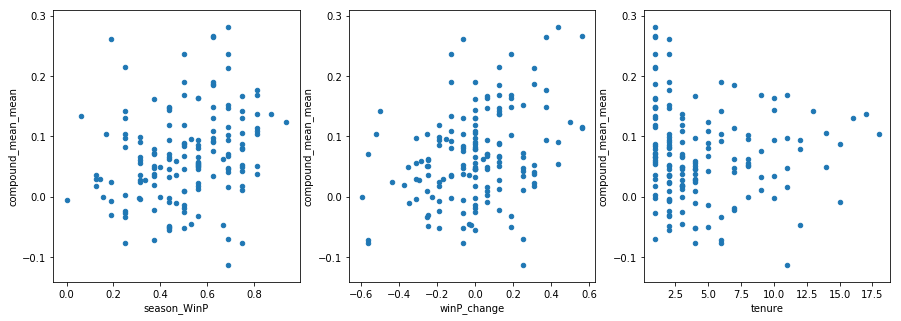

In [40]:
fig, axes = plt.subplots(1,3, figsize = [15, 5])
coaches_fit_df.plot.scatter('season_WinP', 'compound_mean_mean', ax = axes[0]);
coaches_fit_df.plot.scatter('winP_change', 'compound_mean_mean', ax = axes[1]);
coaches_fit_df.plot.scatter('tenure', 'compound_mean_mean', ax = axes[2]);

In [41]:
coaches_fit_df.groupby('race').agg(['mean', 'count'])['compound_mean_mean']

,mean,count
race,,
B,0.050933,24
W,0.071046,130


#### Regression model full - no clustering

In [45]:
'''model = sm.WLS( fit_df['compound_mean_mean'].values,
               fit_df[['youth', 'oldness', 'Wins', 'W', 'M', 'short', 'tall',
                       'PS/G', '3P%' , 'TRB%', 'AST%','BLK%', 'STL%', 'OWS', 'DWS']],
               fit_df['user_count']).fit()'''
coach_model = smf.wls( formula = 'compound_mean_mean ~ age + tenure + rookie + season_WinP + winP_change + career_WinP + C(race)',
                data = coaches_fit_df,
               weights = 1 / (coaches_fit_df['compound_mean_std'] / np.sqrt(coaches_fit_df['user_count'])),
#                missing='raise'   
               ).fit()

In [46]:
coach_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.330
Model:                            WLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     10.29
Date:                Sun, 16 Dec 2018   Prob (F-statistic):           1.88e-10
Time:                        20:29:31   Log-Likelihood:                 198.93
No. Observations:                 154   AIC:                            -381.9
Df Residuals:                     146   BIC:                            -357.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0847      0.049      1.721      0.087      -0.013       0.182
rookie[T.True]     0.0668      0.016      4.306      0.000       0.036       0.097
C(race)[T.W]       0.0158      0.016      1.001      0.318      -0.015       0.047
age               -0.0021      0.001     -2.530      0.012      -0.004      -0.000
tenure             0.0020      0.001      1.342      0.182      -0.001       0.005
season_WinP        0.1439      0.044      3.302      0.001       0.058       0.230
winP_change        0.0259      0.031      0.823      0.412      -0.036       0.088
career_WinP       -0.0198      0.070     -0.285      0.776      -0.157       0.118
==============================================================================
Omnibus:                        3.852   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.146   Jarque-Bera (JB):                4.215
Skew:                          -0.145   Prob(JB):                        0.122
Kurtosis:                       3.757   Cond. No.                         843.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Regression model full - with clustering

In [57]:
'''model = sm.WLS( fit_df['compound_mean_mean'].values,
               fit_df[['youth', 'oldness', 'Wins', 'W', 'M', 'short', 'tall',
                       'PS/G', '3P%' , 'TRB%', 'AST%','BLK%', 'STL%', 'OWS', 'DWS']],
               fit_df['user_count']).fit()'''
coach_model = smf.wls( formula = 'compound_mean_mean ~ age + tenure + rookie + career_WinP + winP_change + season_WinP + C(race)',
                data = coaches_fit_df,
               weights = 1 / (coaches_fit_df['compound_mean_std'] / np.sqrt(coaches_fit_df['user_count'])),
#                missing='raise'   
               ).fit(cov_type='cluster', cov_kwds={'groups' : coaches_fit_df['fuzzy_name']})

In [58]:
coach_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.330
Model:                            WLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     9.790
Date:                Sun, 16 Dec 2018   Prob (F-statistic):           9.20e-08
Time:                        21:03:36   Log-Likelihood:                 198.93
No. Observations:                 154   AIC:                            -381.9
Df Residuals:                     146   BIC:                            -357.6
Df Model:                           7                                         
Covariance Type:              cluster                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0847      0.061      1.400      0.162      -0.034       0.203
rookie[T.True]     0.0668      0.017      4.012      0.000       0.034       0.099
C(race)[T.W]       0.0158      0.017      0.910      0.363      -0.018       0.050
age               -0.0021      0.001     -2.040      0.041      -0.004   -8.36e-05
tenure             0.0020      0.002      1.158      0.247      -0.001       0.005
career_WinP       -0.0198      0.087     -0.228      0.820      -0.190       0.151
winP_change        0.0259      0.034      0.771      0.440      -0.040       0.092
season_WinP        0.1439      0.046      3.140      0.002       0.054       0.234
==============================================================================
Omnibus:                        3.852   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.146   Jarque-Bera (JB):                4.215
Skew:                          -0.145   Prob(JB):                        0.122
Kurtosis:                       3.757   Cond. No.                         843.
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
"""

#### Coaches regression full with interaction - clustered errors

In [49]:
coaches_fit_df['demean_WinP'] = coaches_fit_df['season_WinP'] - coaches_fit_df['season_WinP'].mean()

C:\Users\map22\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [59]:
'''model = sm.WLS( fit_df['compound_mean_mean'].values,
               fit_df[['youth', 'oldness', 'Wins', 'W', 'M', 'short', 'tall',
                       'PS/G', '3P%' , 'TRB%', 'AST%','BLK%', 'STL%', 'OWS', 'DWS']],
               fit_df['user_count']).fit()'''
coach_model_clustered = smf.wls( formula = 'compound_mean_mean ~ age + tenure + rookie + winP_change + career_WinP + demean_WinP * C(race)',
                data = coaches_fit_df,
               weights = 1 / (coaches_fit_df['compound_mean_std'] / np.sqrt(coaches_fit_df['user_count'])),
#                missing='raise'   
               ).fit(cov_type='cluster', cov_kwds={'groups' : coaches_fit_df['fuzzy_name']})

In [60]:
coach_model_clustered.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.333
Model:                            WLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     10.38
Date:                Sun, 16 Dec 2018   Prob (F-statistic):           1.33e-08
Time:                        21:05:33   Log-Likelihood:                 199.24
No. Observations:                 154   AIC:                            -380.5
Df Residuals:                     145   BIC:                            -353.1
Df Model:                           8                                         
Covariance Type:              cluster                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.1593      0.063      2.547      0.011       0.037       0.282
rookie[T.True]               0.0667      0.017      3.989      0.000       0.034       0.100
C(race)[T.W]                 0.0190      0.018      1.060      0.289      -0.016       0.054
age                         -0.0023      0.001     -2.089      0.037      -0.004      -0.000
tenure                       0.0021      0.002      1.237      0.216      -0.001       0.005
winP_change                  0.0234      0.034      0.687      0.492      -0.043       0.090
career_WinP                 -0.0169      0.087     -0.194      0.846      -0.187       0.154
demean_WinP                  0.1002      0.065      1.536      0.125      -0.028       0.228
demean_WinP:C(race)[T.W]     0.0534      0.059      0.899      0.369      -0.063       0.170
==============================================================================
Omnibus:                        4.198   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.123   Jarque-Bera (JB):                4.971
Skew:                          -0.124   Prob(JB):                       0.0833
Kurtosis:                       3.844   Cond. No.                     1.07e+03
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
[2] The condition number is large, 1.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Coaches regression performance only - clustered errors

In [62]:
'''model = sm.WLS( fit_df['compound_mean_mean'].values,
               fit_df[['youth', 'oldness', 'Wins', 'W', 'M', 'short', 'tall',
                       'PS/G', '3P%' , 'TRB%', 'AST%','BLK%', 'STL%', 'OWS', 'DWS']],
               fit_df['user_count']).fit()'''
coach_model_clustered = smf.wls( formula = 'compound_mean_mean ~ winP_change + career_WinP + season_WinP',
                data = coaches_fit_df,
               weights = 1 / (coaches_fit_df['compound_mean_std'] / np.sqrt(coaches_fit_df['user_count'])),
#                missing='raise'   
               ).fit(cov_type='cluster', cov_kwds={'groups' : coaches_fit_df['fuzzy_name']})

In [63]:
coach_model_clustered.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.201
Model:                            WLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     9.281
Date:                Sun, 16 Dec 2018   Prob (F-statistic):           4.94e-05
Time:                        21:10:51   Log-Likelihood:                 185.33
No. Observations:                 154   AIC:                            -362.7
Df Residuals:                     150   BIC:                            -350.5
Df Model:                           3                                         
Covariance Type:              cluster                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0303      0.035      0.867      0.386      -0.038       0.099
winP_change     0.0886      0.040      2.214      0.027       0.010       0.167
career_WinP    -0.0144      0.099     -0.145      0.885      -0.209       0.180
season_WinP     0.0927      0.050      1.838      0.066      -0.006       0.192
==============================================================================
Omnibus:                        6.355   Durbin-Watson:                   1.708
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                8.859
Skew:                           0.192   Prob(JB):                       0.0119
Kurtosis:                       4.110   Cond. No.                         18.4
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
"""

#### Coaches regression performance + race - clustered errors

In [64]:
'''model = sm.WLS( fit_df['compound_mean_mean'].values,
               fit_df[['youth', 'oldness', 'Wins', 'W', 'M', 'short', 'tall',
                       'PS/G', '3P%' , 'TRB%', 'AST%','BLK%', 'STL%', 'OWS', 'DWS']],
               fit_df['user_count']).fit()'''
coach_model_clustered = smf.wls( formula = 'compound_mean_mean ~ winP_change + career_WinP + season_WinP + C(race)',
                data = coaches_fit_df,
               weights = 1 / (coaches_fit_df['compound_mean_std'] / np.sqrt(coaches_fit_df['user_count'])),
#                missing='raise'   
               ).fit(cov_type='cluster', cov_kwds={'groups' : coaches_fit_df['fuzzy_name']})

In [65]:
coach_model_clustered.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.205
Model:                            WLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     7.846
Date:                Sun, 16 Dec 2018   Prob (F-statistic):           4.82e-05
Time:                        21:35:38   Log-Likelihood:                 185.67
No. Observations:                 154   AIC:                            -361.3
Df Residuals:                     149   BIC:                            -346.2
Df Model:                           4                                         
Covariance Type:              cluster                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0219      0.037      0.591      0.555      -0.051       0.095
C(race)[T.W]     0.0136      0.018      0.763      0.445      -0.021       0.048
winP_change      0.0904      0.040      2.273      0.023       0.012       0.168
career_WinP     -0.0171      0.099     -0.173      0.863      -0.211       0.176
season_WinP      0.0889      0.051      1.730      0.084      -0.012       0.190
==============================================================================
Omnibus:                        6.403   Durbin-Watson:                   1.714
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                9.188
Skew:                           0.178   Prob(JB):                       0.0101
Kurtosis:                       4.142   Cond. No.                         22.6
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
"""

#### Coaches regression performance + tenure - clustered errors

In [66]:
'''model = sm.WLS( fit_df['compound_mean_mean'].values,
               fit_df[['youth', 'oldness', 'Wins', 'W', 'M', 'short', 'tall',
                       'PS/G', '3P%' , 'TRB%', 'AST%','BLK%', 'STL%', 'OWS', 'DWS']],
               fit_df['user_count']).fit()'''
coach_model_clustered = smf.wls( formula = 'compound_mean_mean ~ winP_change + career_WinP + season_WinP + age + tenure + rookie',
                data = coaches_fit_df,
               weights = 1 / (coaches_fit_df['compound_mean_std'] / np.sqrt(coaches_fit_df['user_count'])),
#                missing='raise'   
               ).fit(cov_type='cluster', cov_kwds={'groups' : coaches_fit_df['fuzzy_name']})

In [67]:
coach_model_clustered.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.326
Model:                            WLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     10.11
Date:                Sun, 16 Dec 2018   Prob (F-statistic):           1.97e-07
Time:                        21:36:47   Log-Likelihood:                 198.40
No. Observations:                 154   AIC:                            -382.8
Df Residuals:                     147   BIC:                            -361.5
Df Model:                           6                                         
Covariance Type:              cluster                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0908      0.063      1.438      0.150      -0.033       0.215
rookie[T.True]     0.0662      0.017      3.971      0.000       0.034       0.099
winP_change        0.0228      0.033      0.682      0.495      -0.043       0.088
career_WinP       -0.0125      0.089     -0.141      0.888      -0.186       0.161
season_WinP        0.1495      0.045      3.336      0.001       0.062       0.237
age               -0.0021      0.001     -1.948      0.051      -0.004    1.24e-05
tenure             0.0017      0.002      0.955      0.340      -0.002       0.005
==============================================================================
Omnibus:                        3.227   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.199   Jarque-Bera (JB):                3.320
Skew:                          -0.119   Prob(JB):                        0.190
Kurtosis:                       3.678   Cond. No.                         843.
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
"""